In [1]:
##Imports

import pandas as pd
import requests
import warnings
from requests.packages.urllib3.exceptions import InsecureRequestWarning
import locale
from datetime import datetime
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML

In [2]:
## Convert datetime and set Cipher

#Set local to match the date in german speaking countries
locale.setlocale(locale.LC_ALL, 'de_AT.utf8')
requests.packages.urllib3.util.ssl_.DEFAULT_CIPHERS += 'HIGH:!DH:!aNULL'
try:
    requests.packages.urllib3.contrib.pyopenssl.DEFAULT_SSL_CIPHER_LIST += 'HIGH:!DH:!aNULL'
except AttributeError:
    # no pyopenssl support used / needed / available
    pass

In [3]:
## Download Data 
#import all necessary csv files
url_list = ["http://data.statistik.gv.at/data/OGD_f0760ext_OD_PkwGZL_1.csv", #data
    "http://data.statistik.gv.at/data/OGD_f0760ext_OD_PkwGZL_1_HEADER.csv", #header
    "http://data.statistik.gv.at/data/OGD_f0760ext_OD_PkwGZL_1_C-J59-0.csv", #automarken
    "http://data.statistik.gv.at/data/OGD_f0760ext_OD_PkwGZL_1_C-A10-0.csv", #datum
    "http://data.statistik.gv.at/data/OGD_f0760ext_OD_PkwGZL_1_C-EK7-0.csv" #fahrzeugtyp
]

# empty lists to store the filenames and the dataframes
filename_list = ["data", "header", "marke", "datum", "typ"]
#Own key for filename (same name as filenames but without .csv)
dataframes = {}

warnings.simplefilter('ignore',InsecureRequestWarning)
# Using for loop 
	
#Create the csv
for i in range(len(url_list)):
    open(filename_list[i]+".csv", 'wb').write(requests.get(url_list[i], verify=False).content)

#Read csv and add to dataframe
for i in range(len(filename_list)):
    dataframes[filename_list[i]] = pd.read_csv(filename_list[i]+".csv", sep=";", header=0)


In [4]:
## Merge Data to get a whole dataframe

#Merge to get the automarkenname
dfgesamt = dataframes["data"].merge(dataframes["marke"], left_on=["C-J59-0"], right_on=["code"],  how='left')[['name','C-A10-0', 'C-EK7-0', 'F-ISIS-1']]

#Rename columns
dfgesamt.columns = ['marke', 'C-A10-0', 'C-EK7-0', 'Anzahl']

#Replace Second Column with date
dfgesamt = dfgesamt.merge(dataframes["datum"], left_on=["C-A10-0"], right_on=["code"],  how='left')[['marke','name', 'C-EK7-0', 'Anzahl']]

#Rename columns
dfgesamt.columns = ['marke','Datum', 'C-EK7-0', 'Anzahl']

#ToDo Replace Third Column with Type
dfgesamt = dfgesamt.merge(dataframes["typ"], left_on=["C-EK7-0"], right_on=["code"],  how='left')[['marke','Datum', 'name', 'Anzahl']]

#Rename columns
dfgesamt.columns = ['marke','Datum', 'Fahrzeugtyp', 'Anzahl']


In [5]:
## Convert Datumcolumn to DateType 


#Split Month and Year
dfgesamt[['Monat','Jahr']] = dfgesamt["Datum"].str.split(" ",expand=True,)


#Convert to datetime
dfgesamt["Datum"] = pd.to_datetime(dfgesamt['Jahr'].astype(str)  + dfgesamt['Monat'], format='%Y%B')


#Drop tmp columns
dfgesamt = dfgesamt.drop(columns=['Jahr', 'Monat'])

In [6]:
## Split Data based on Marke

dfList = []
dict_of_regions = dict(iter(dfgesamt.groupby('marke')))

for key in dict_of_regions:
    dfList.append(pd.DataFrame(dict_of_regions.get(key)))


In [7]:
#Get the Amount of cars overall
gesamt= {}
for df in dfList:
    for index, row in df.iterrows():
        if row['Datum'] in gesamt:
            gesamt[row['Datum']] = gesamt[row['Datum']] + row['Anzahl']
        else:
            gesamt[row["Datum"]] = row['Anzahl']

# Visualisierung

None


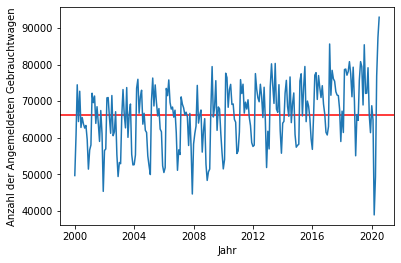

None


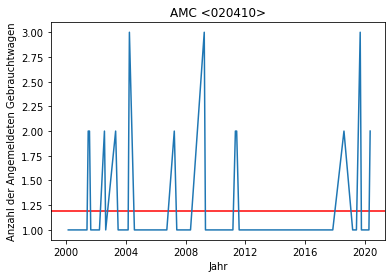

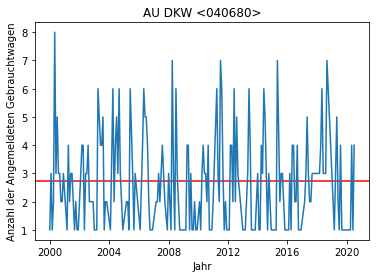

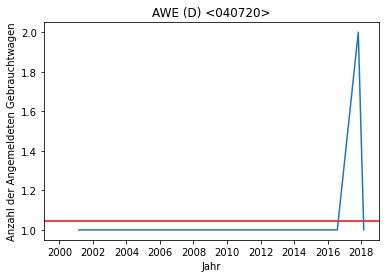

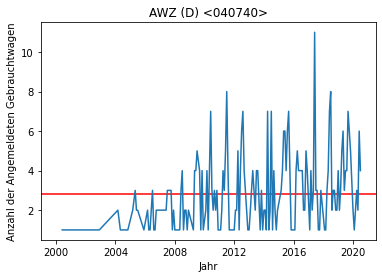

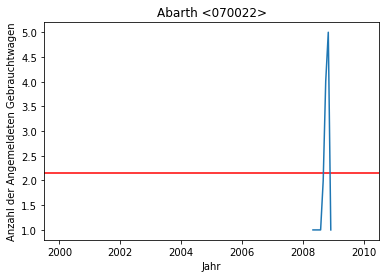

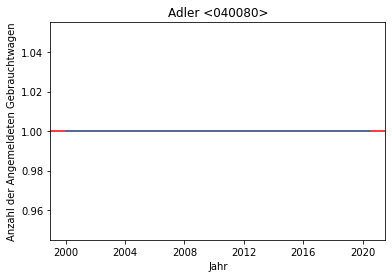

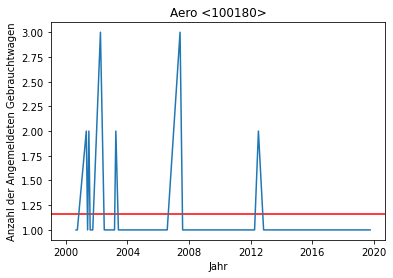

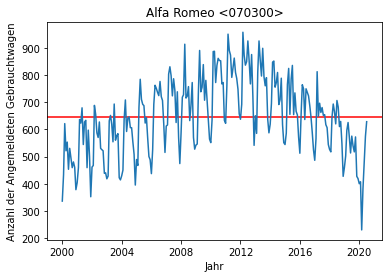

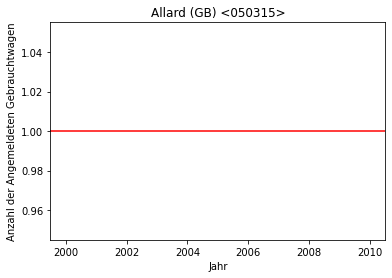

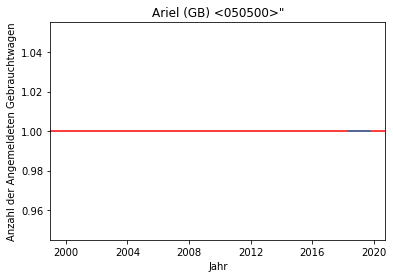

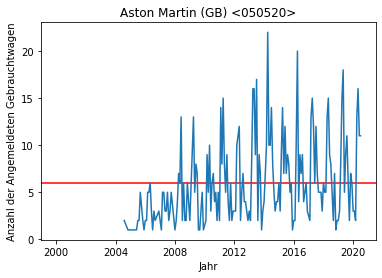

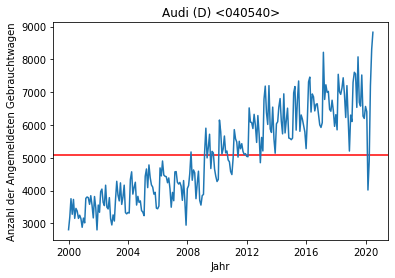

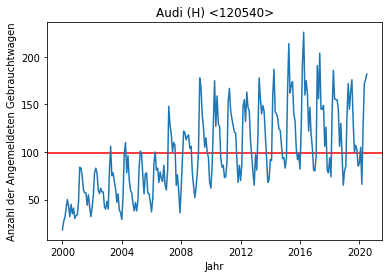

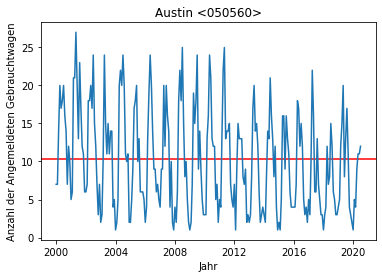

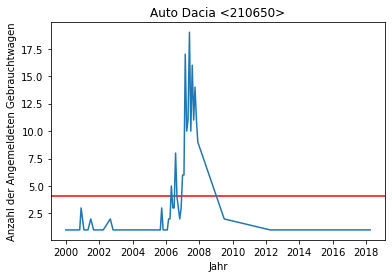

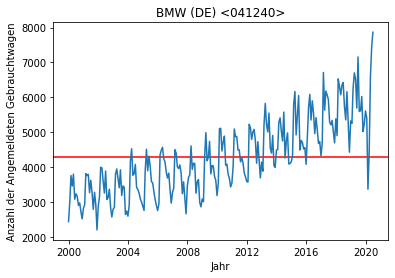

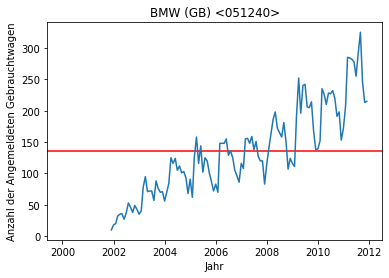

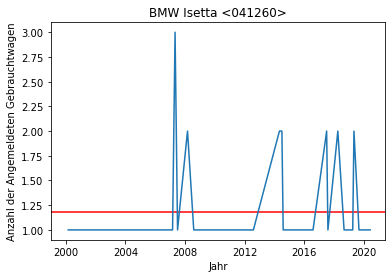

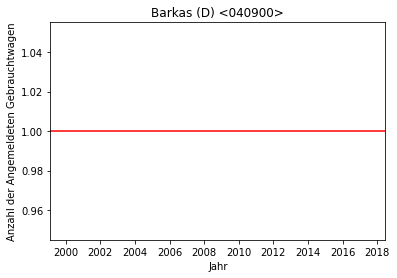

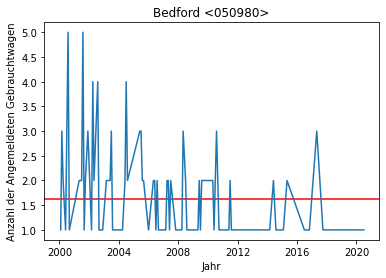

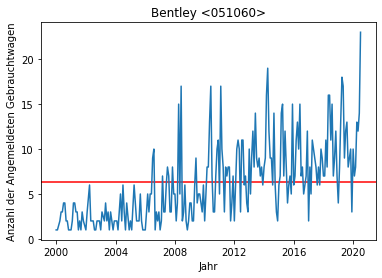

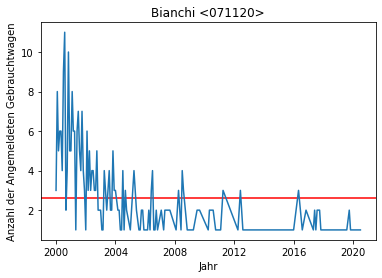

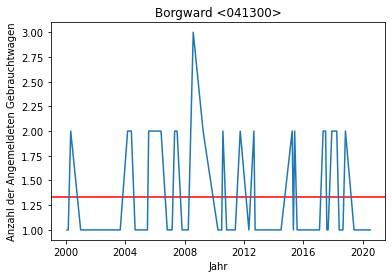

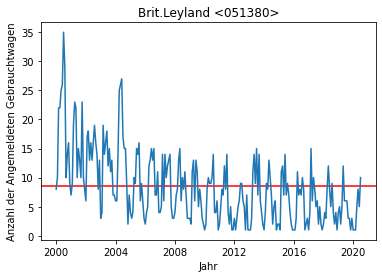

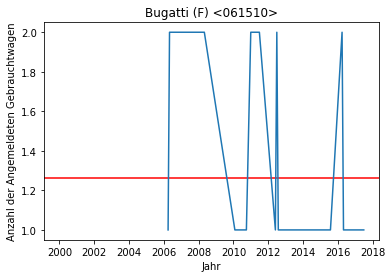

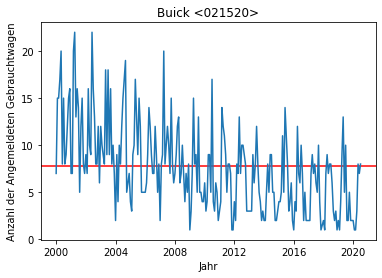

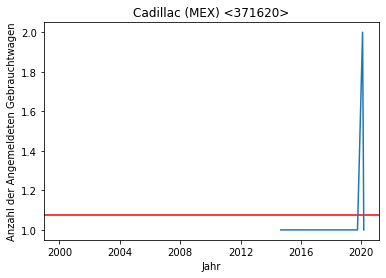

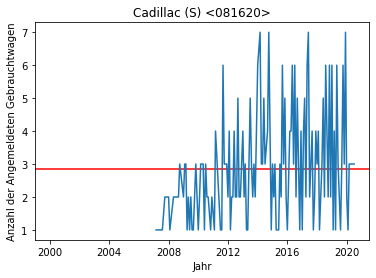

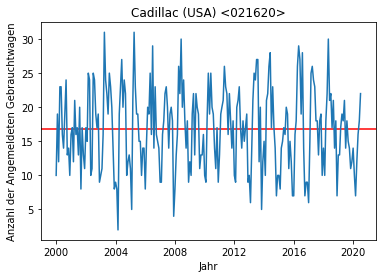

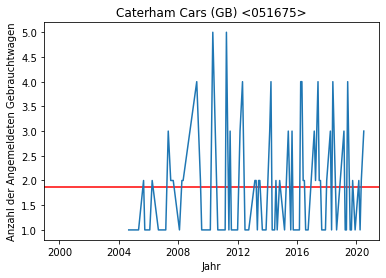

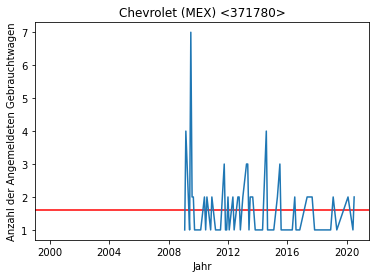

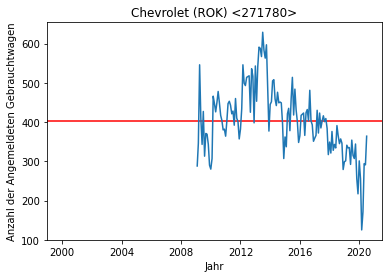

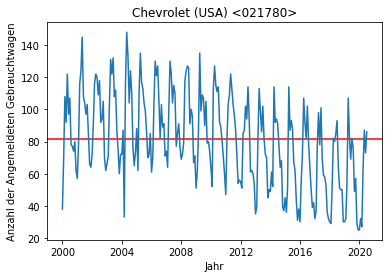

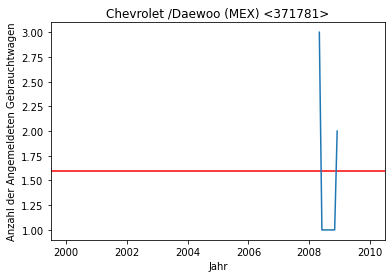

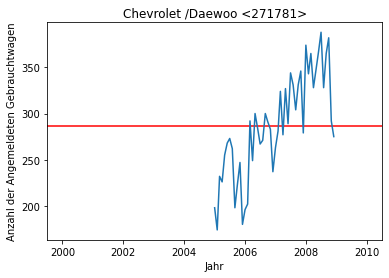

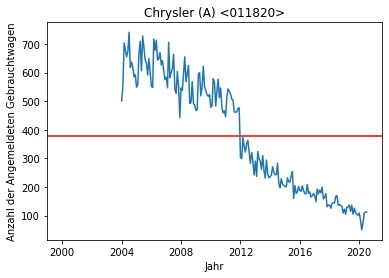

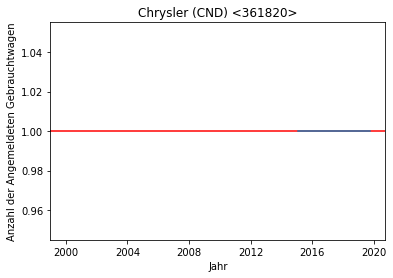

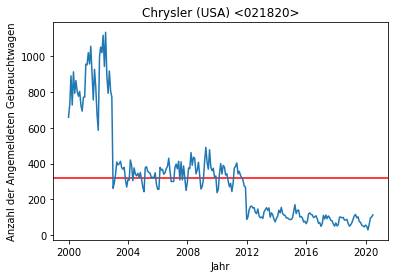

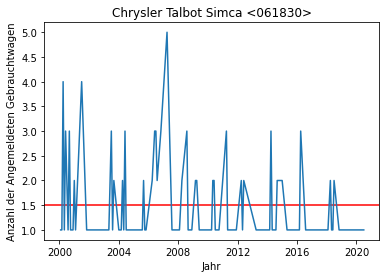

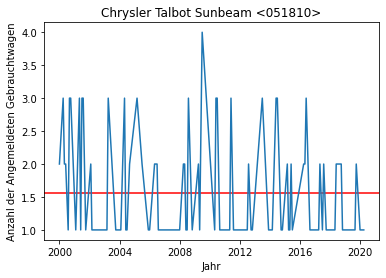

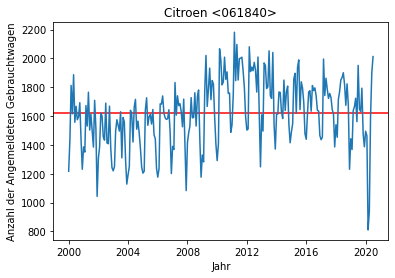

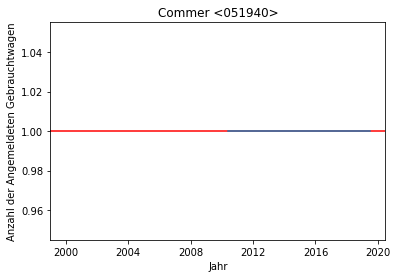

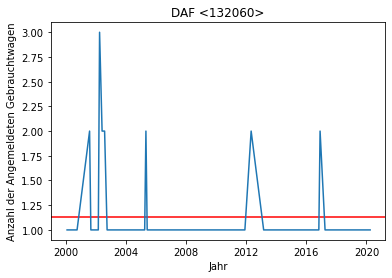

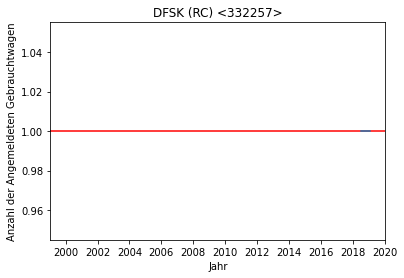

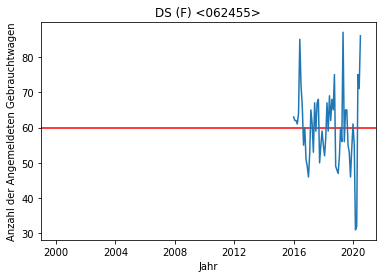

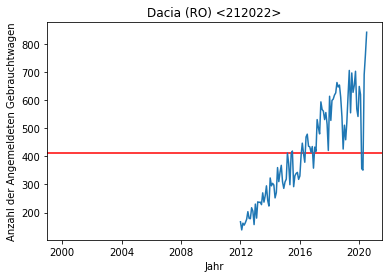

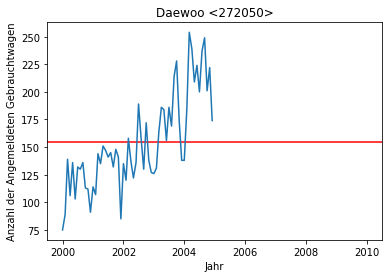

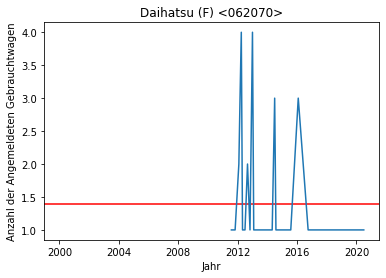

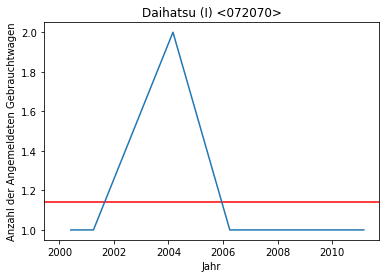

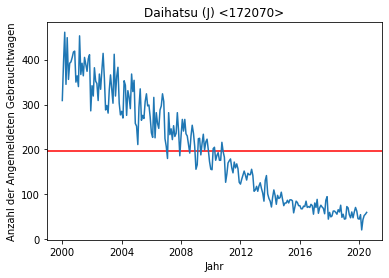

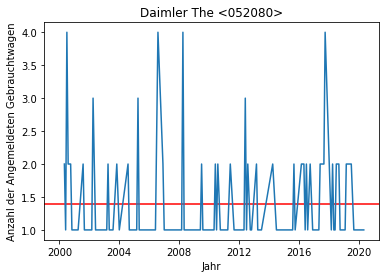

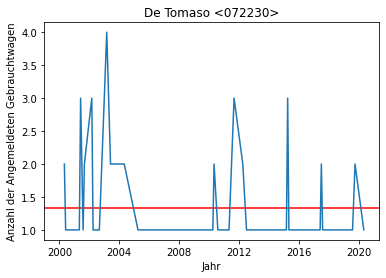

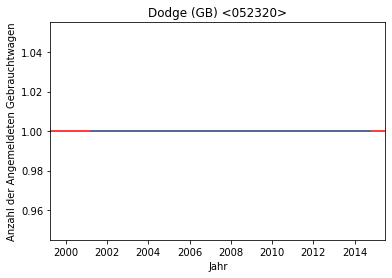

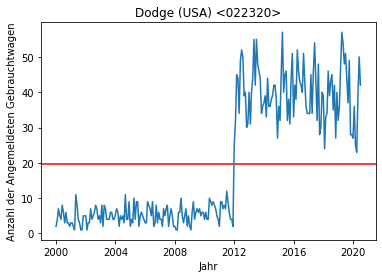

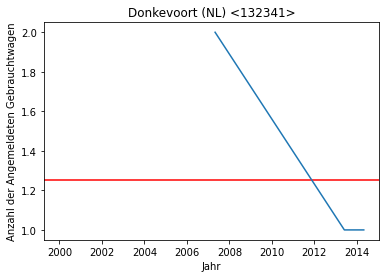

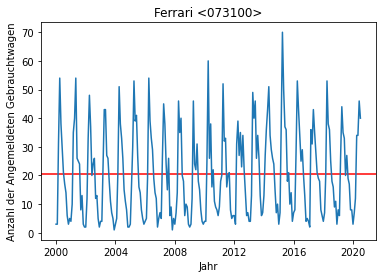

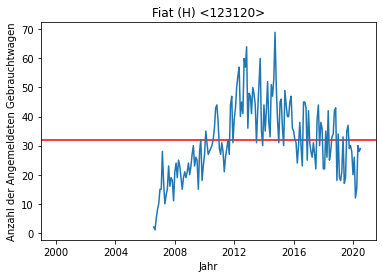

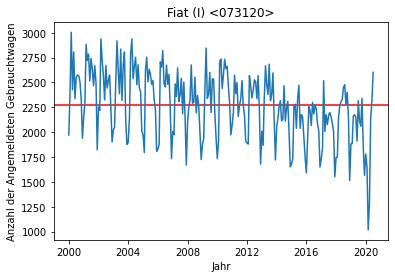

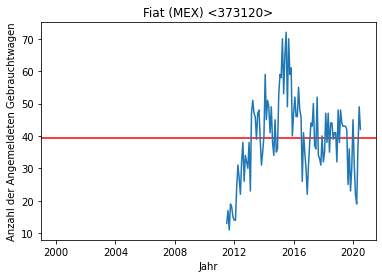

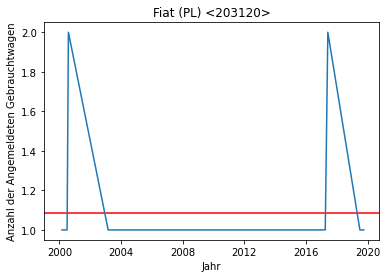

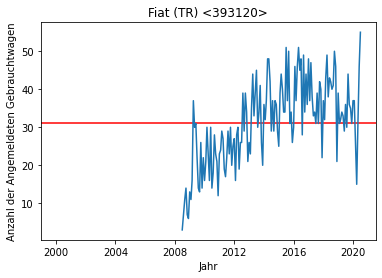

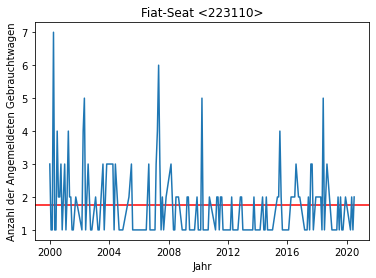

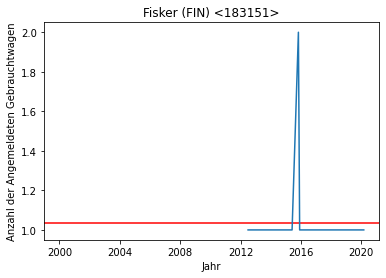

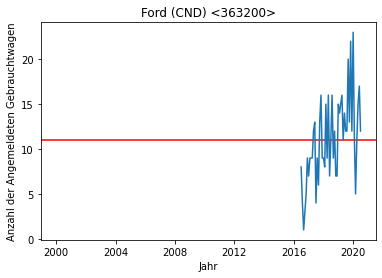

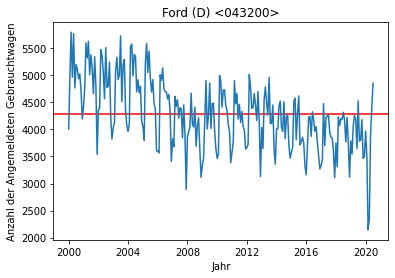

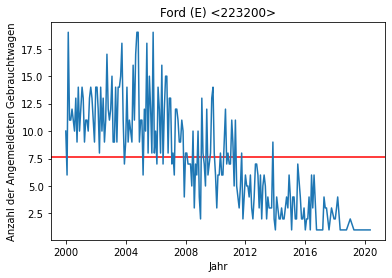

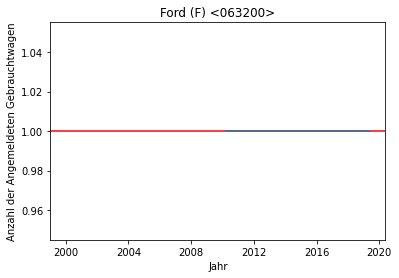

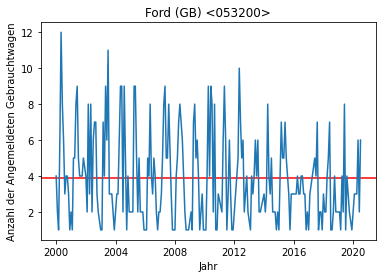

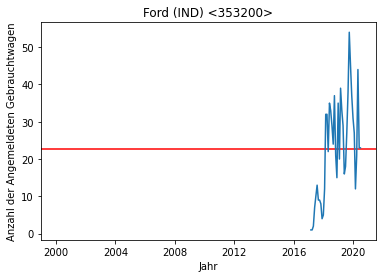

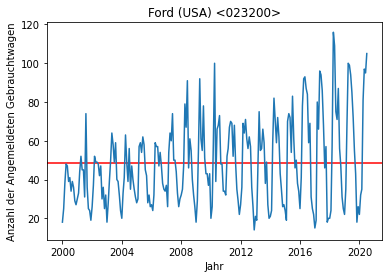

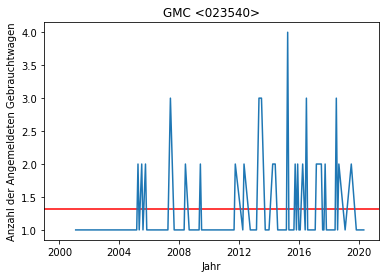

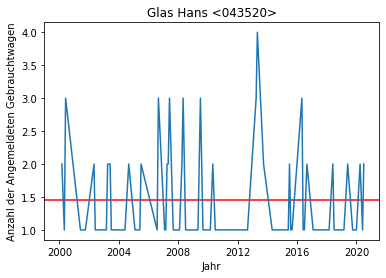

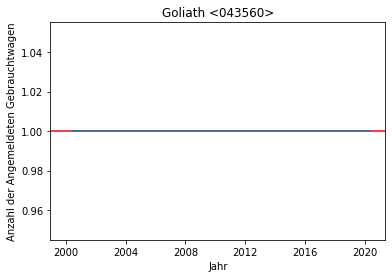

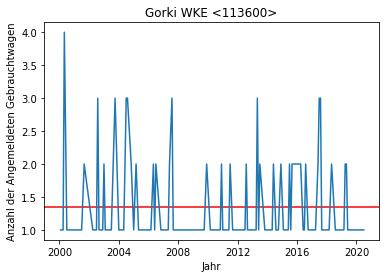

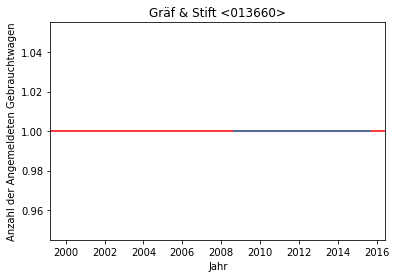

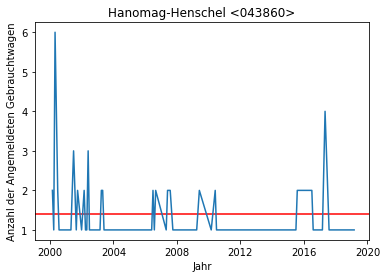

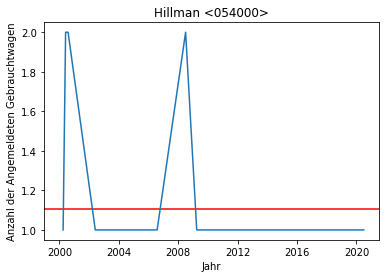

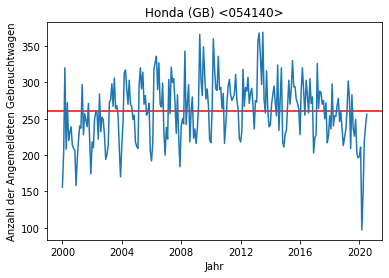

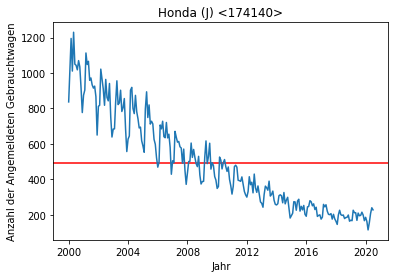

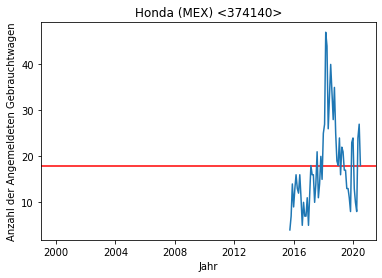

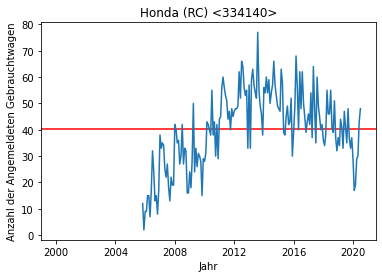

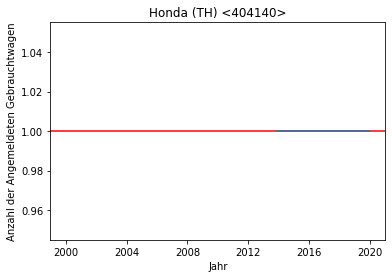

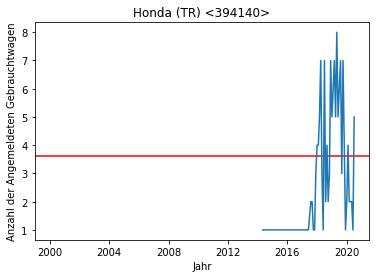

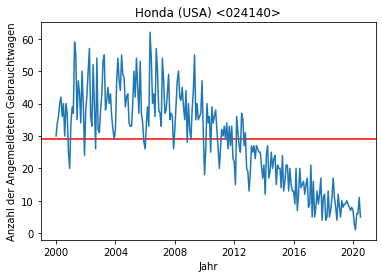

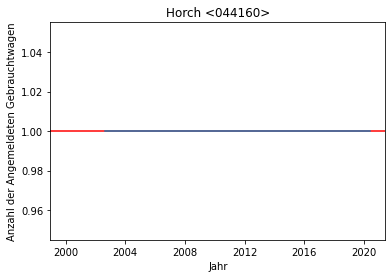

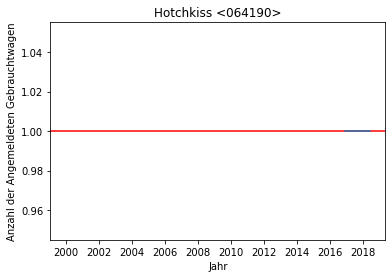

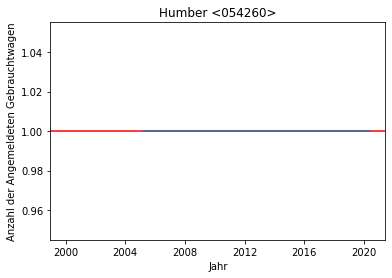

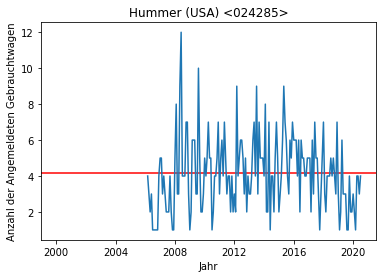

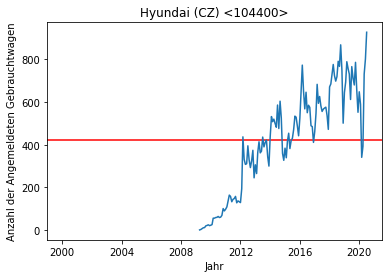

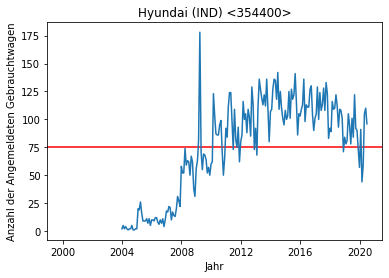

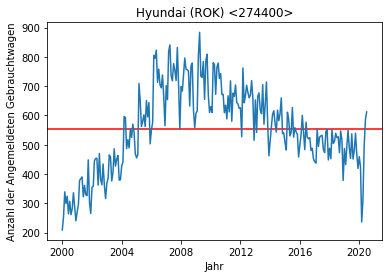

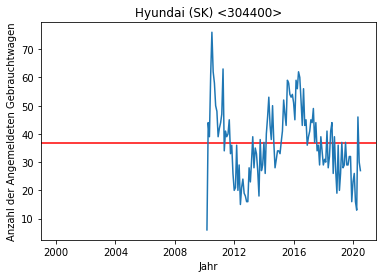

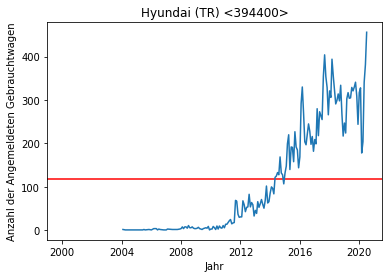

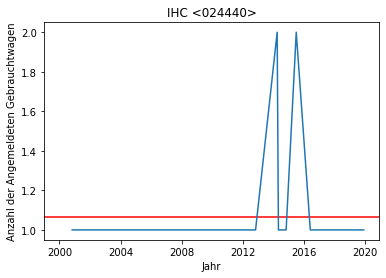

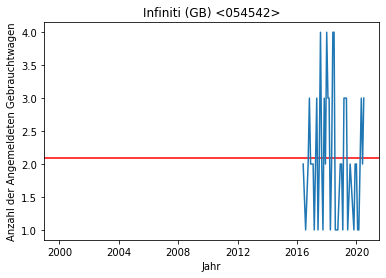

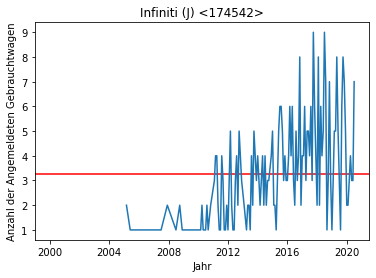

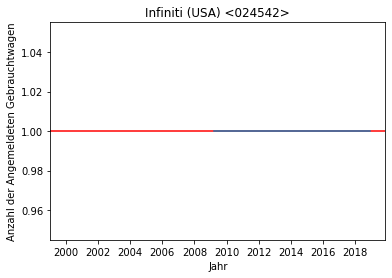

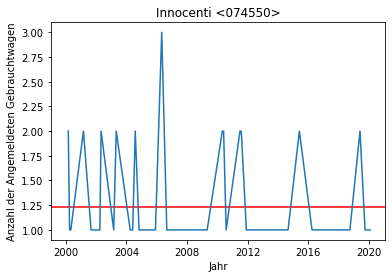

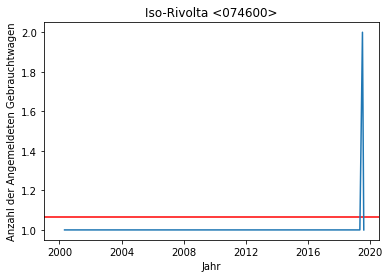

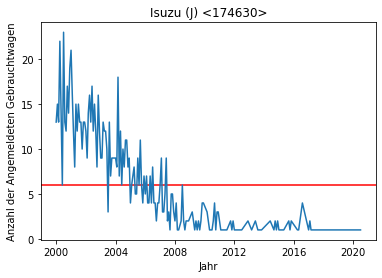

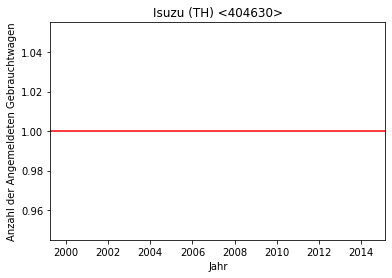

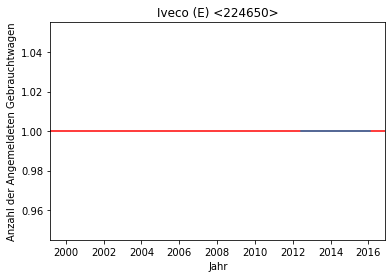

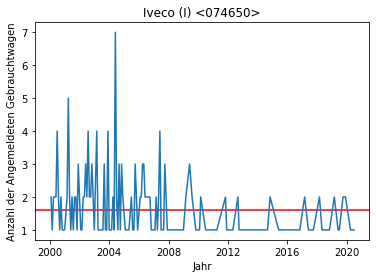

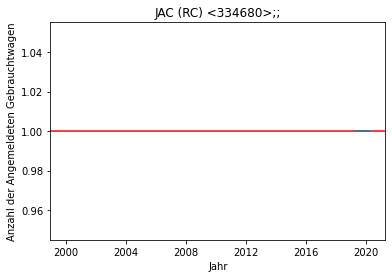

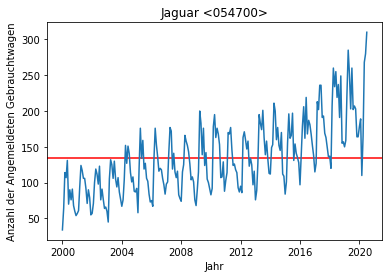

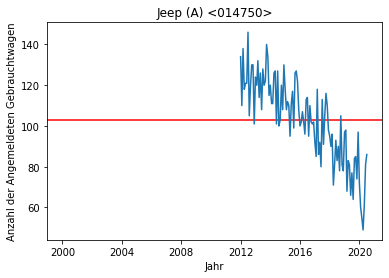

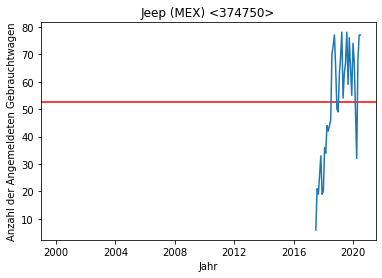

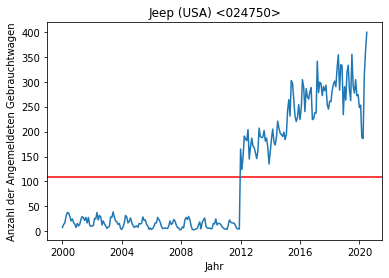

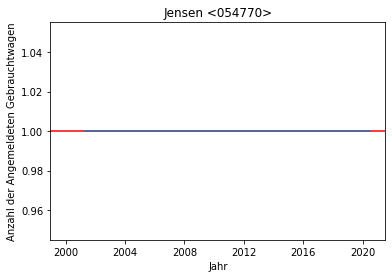

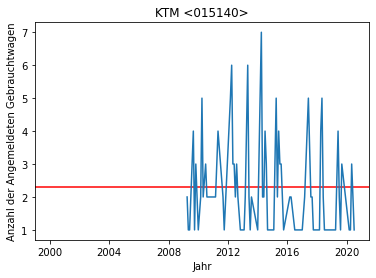

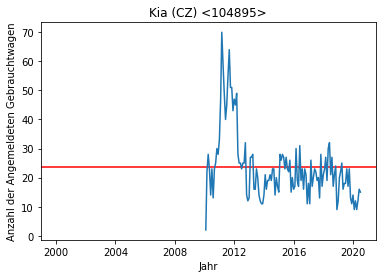

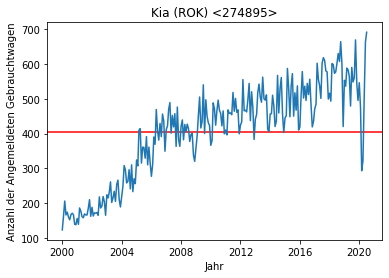

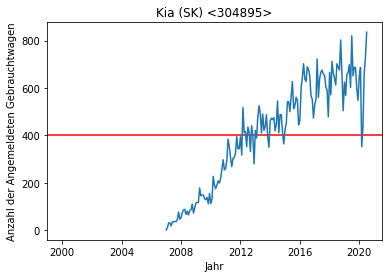

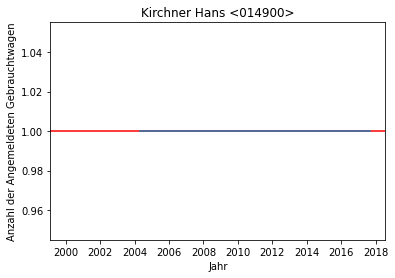

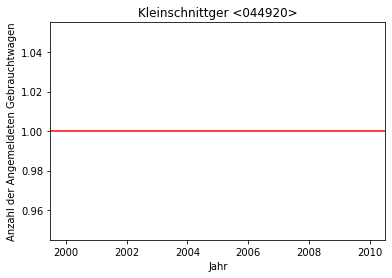

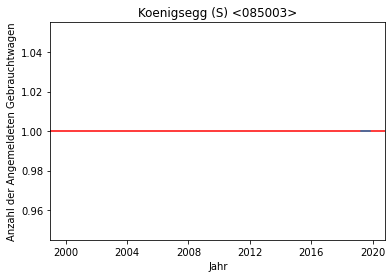

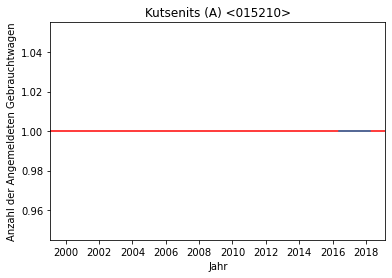

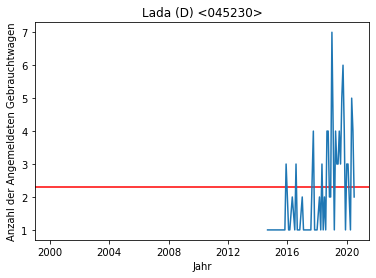

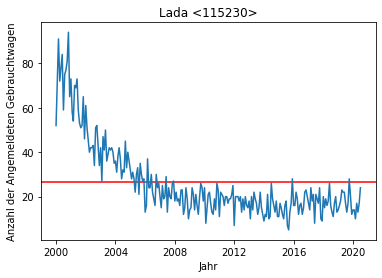

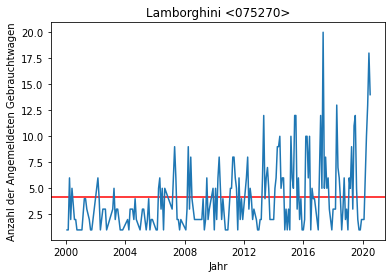

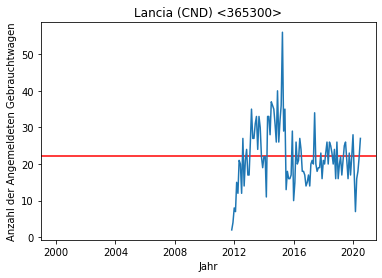

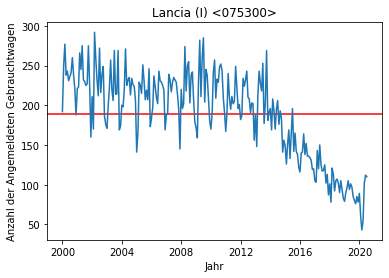

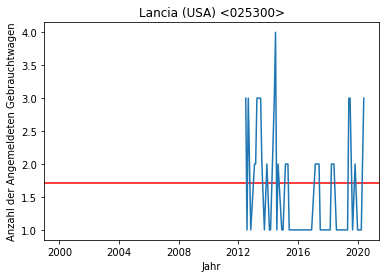

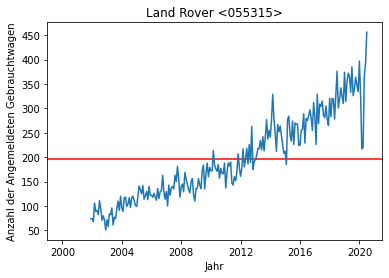

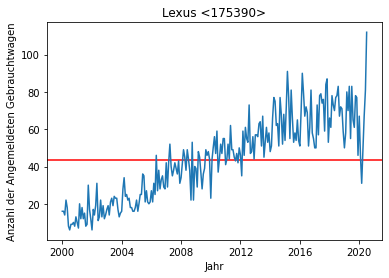

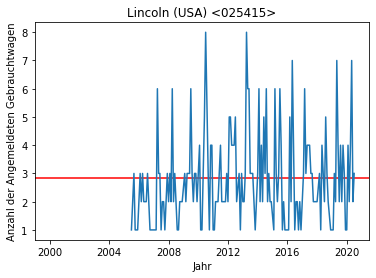

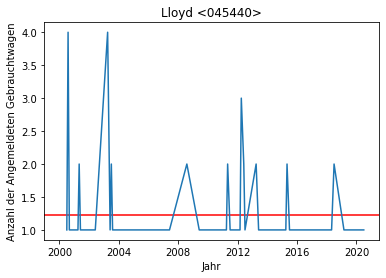

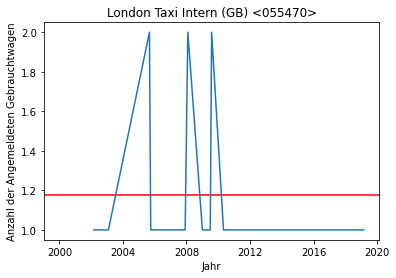

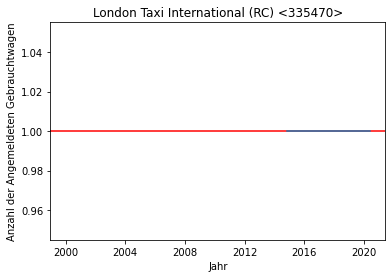

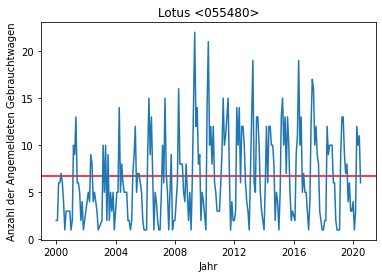

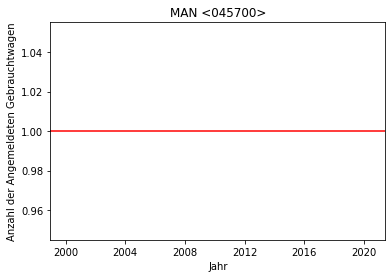

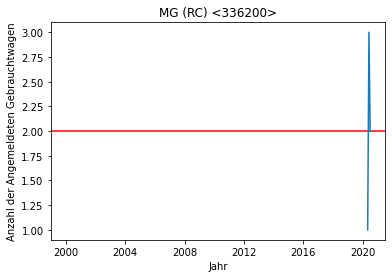

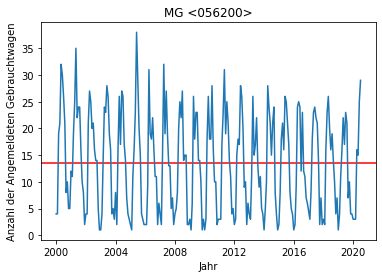

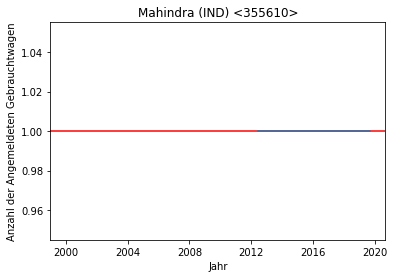

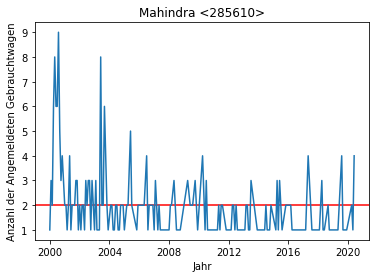

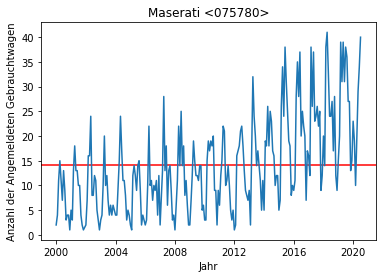

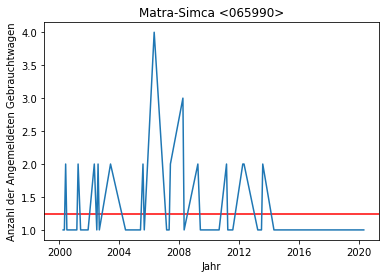

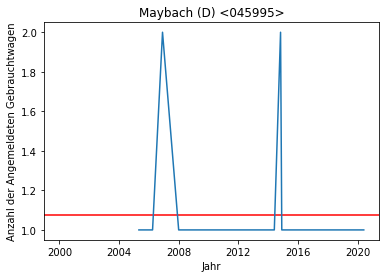

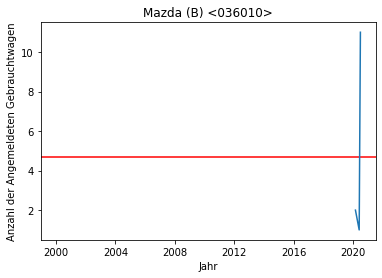

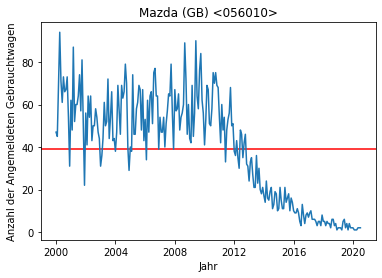

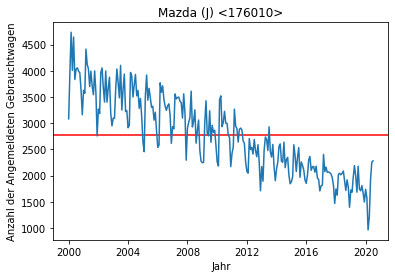

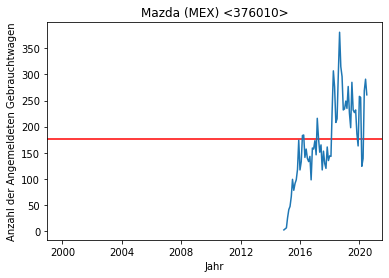

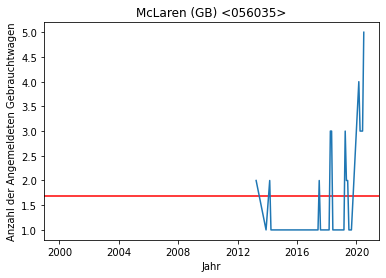

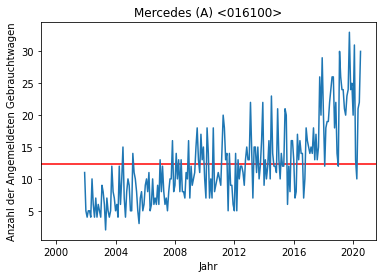

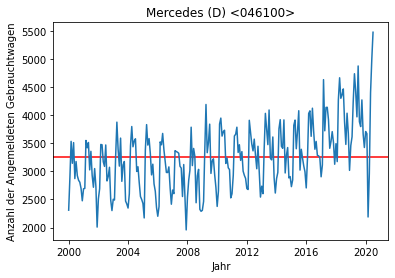

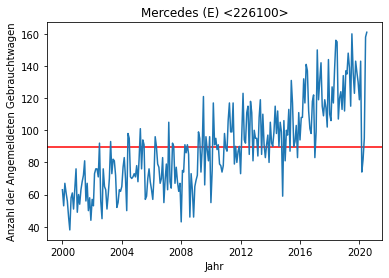

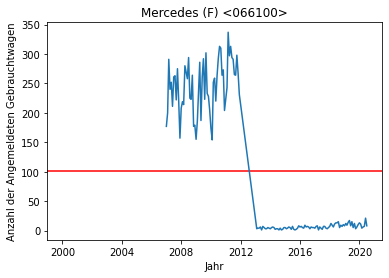

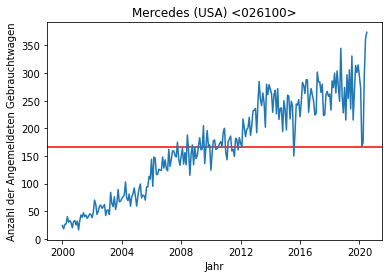

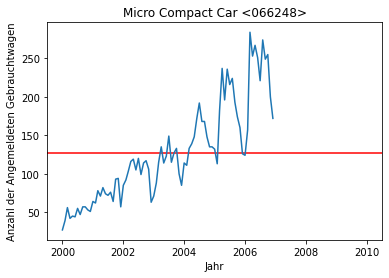

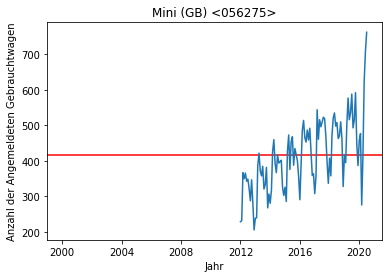

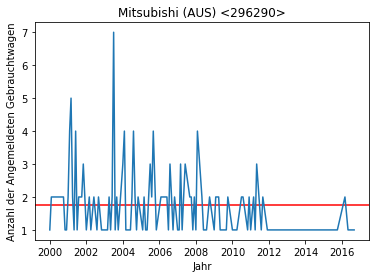

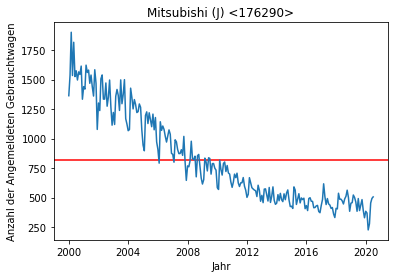

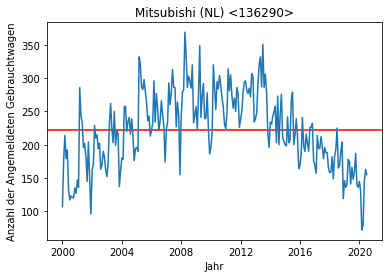

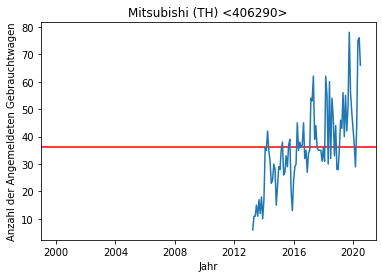

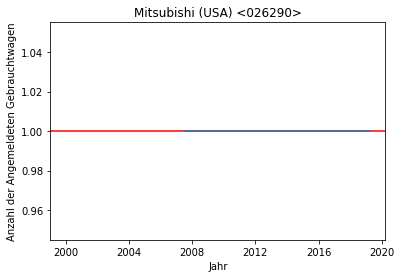

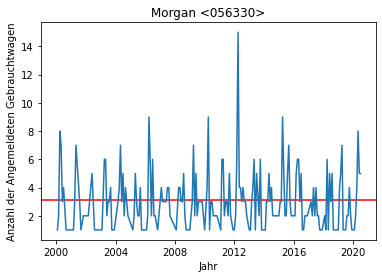

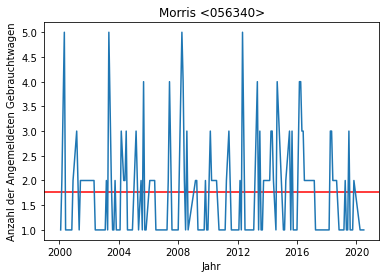

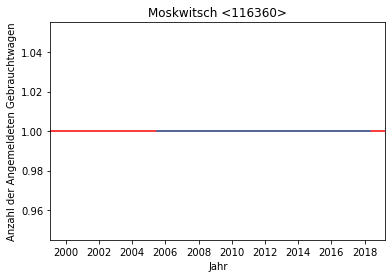

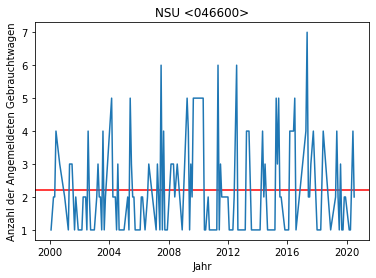

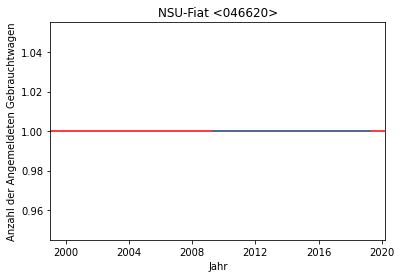

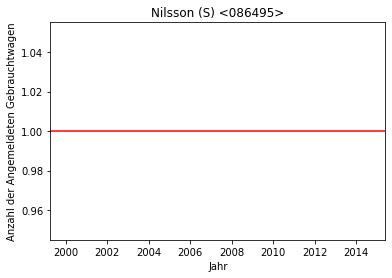

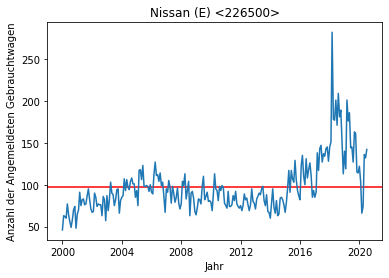

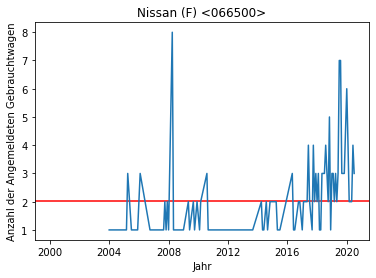

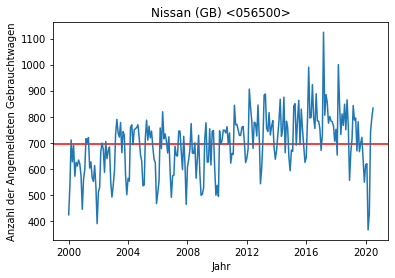

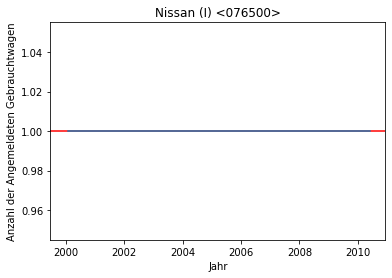

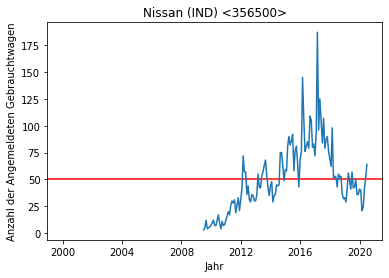

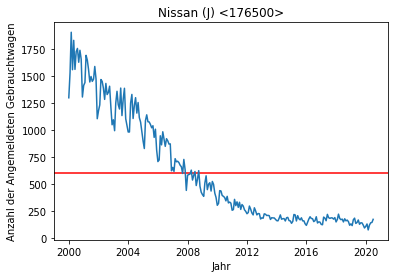

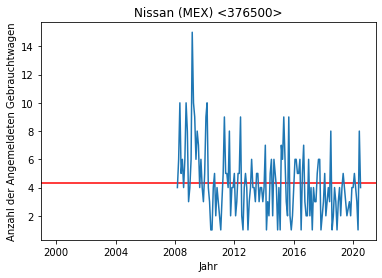

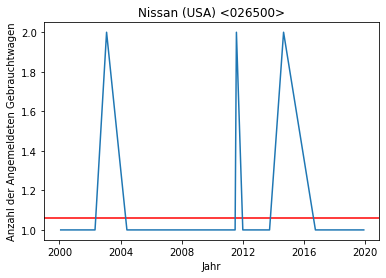

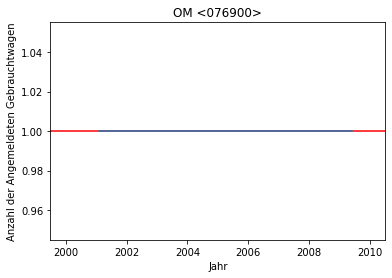

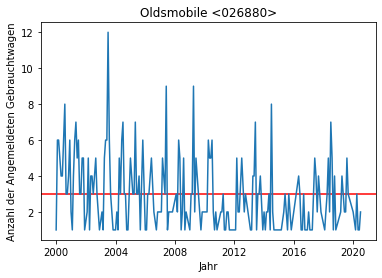

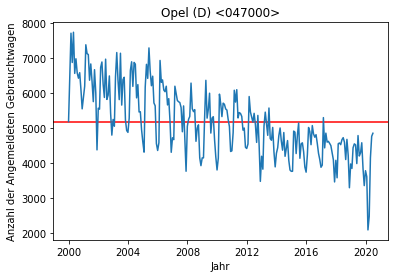

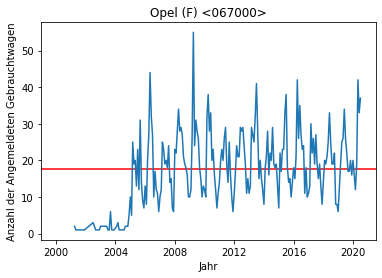

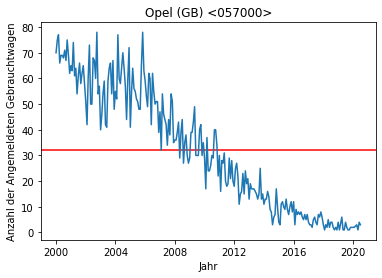

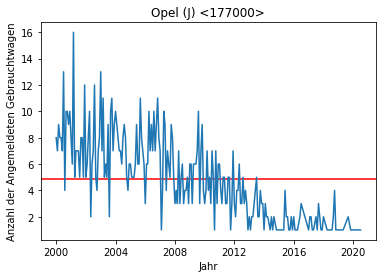

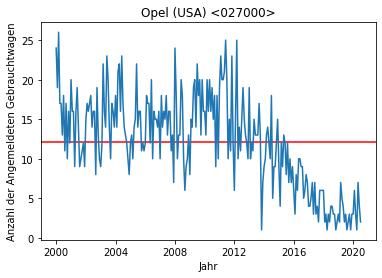

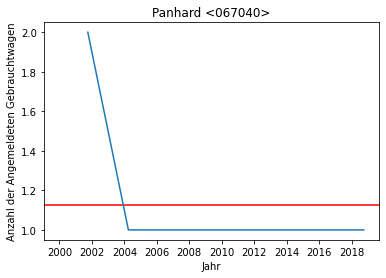

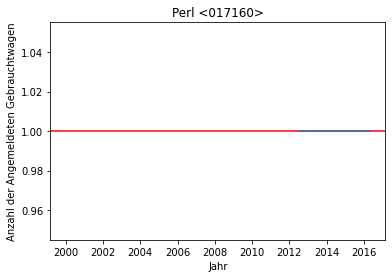

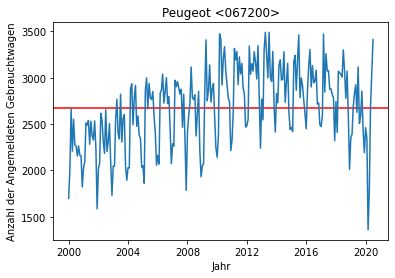

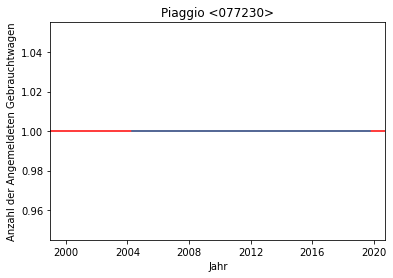

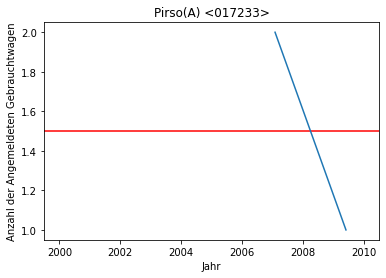

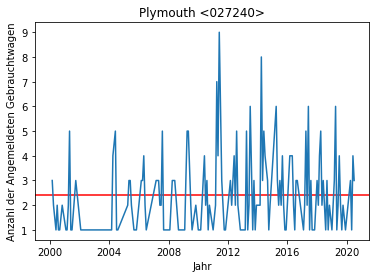

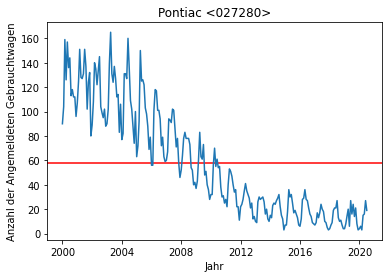

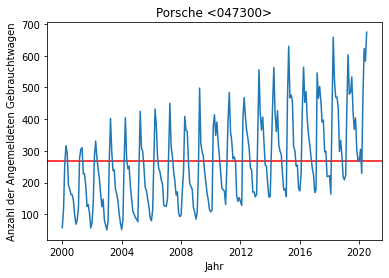

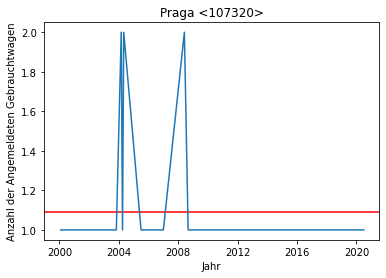

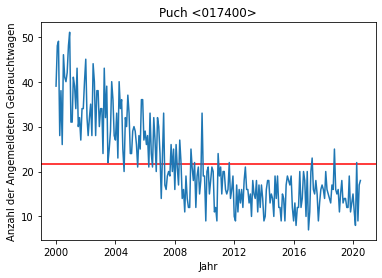

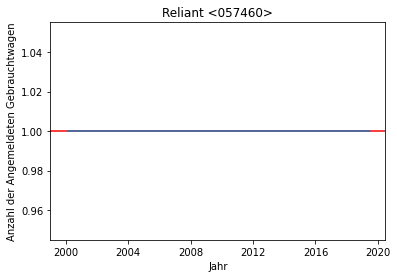

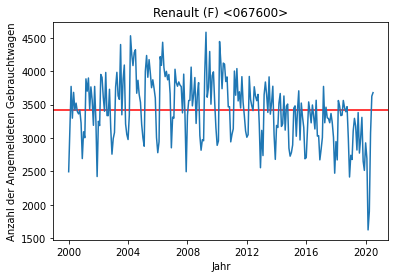

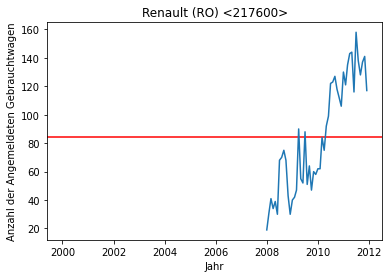

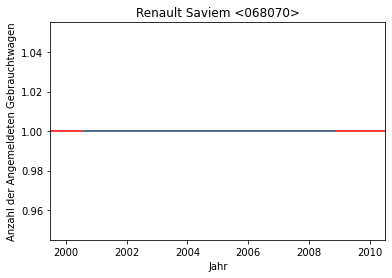

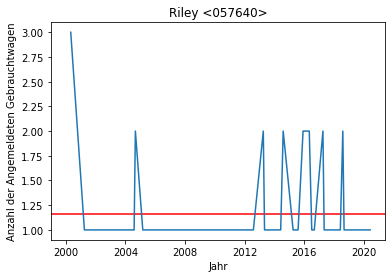

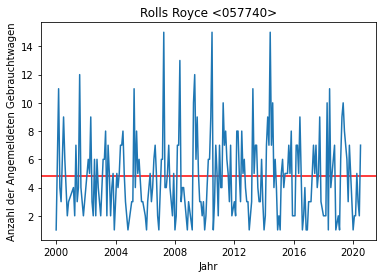

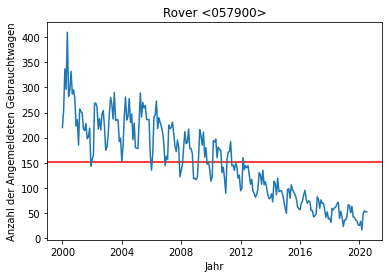

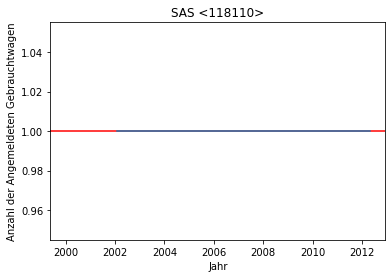

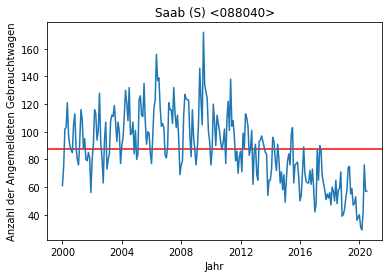

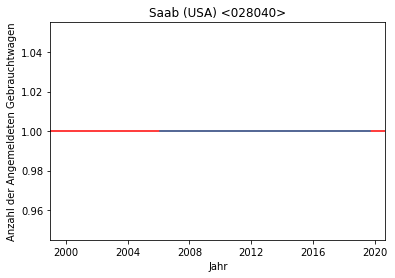

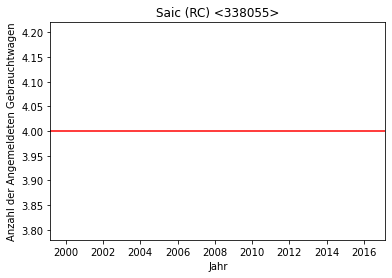

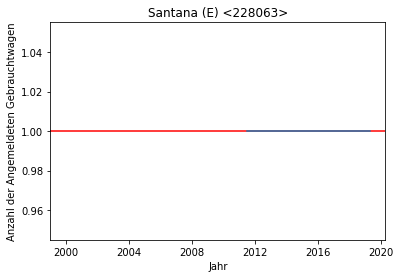

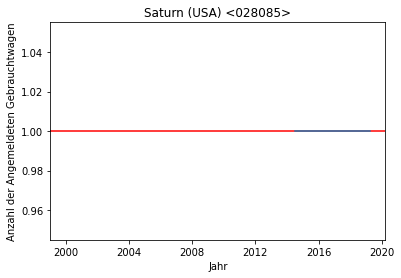

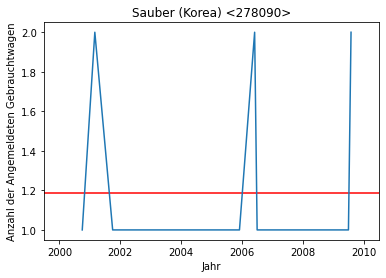

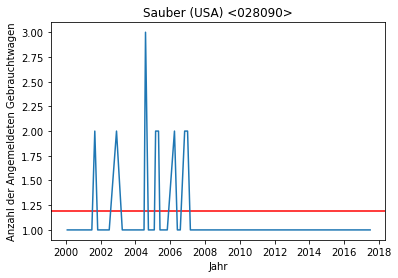

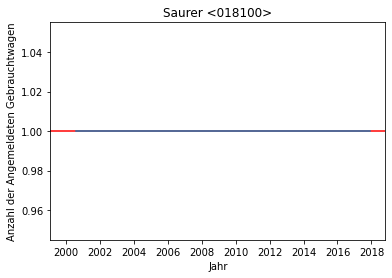

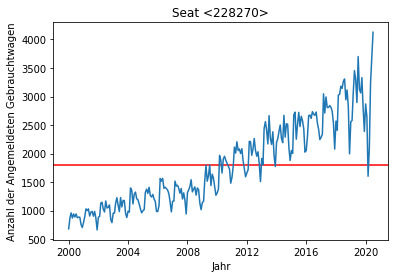

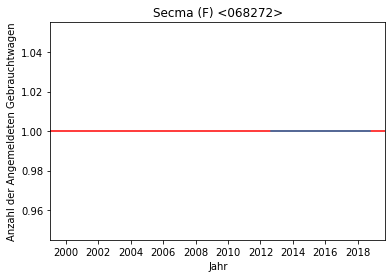

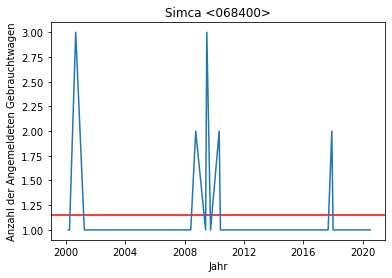

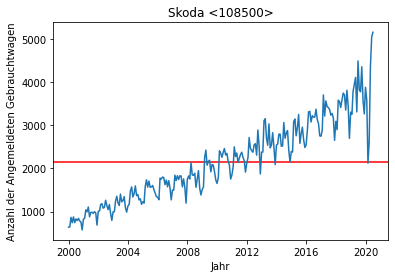

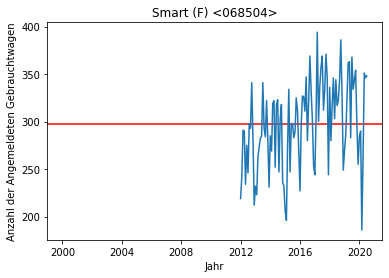

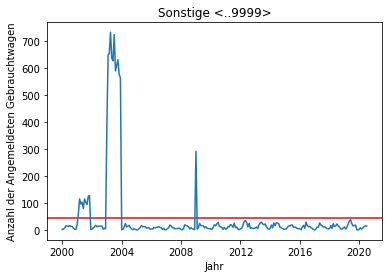

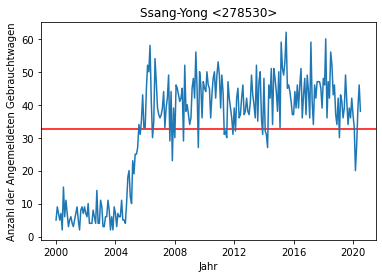

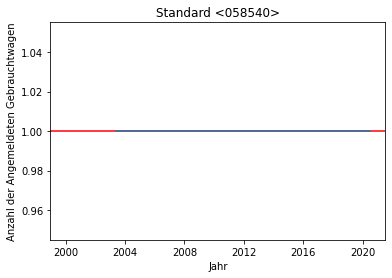

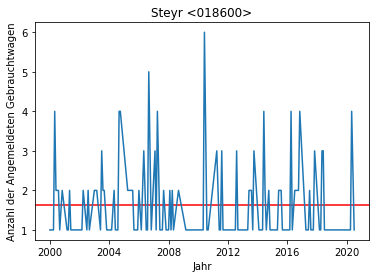

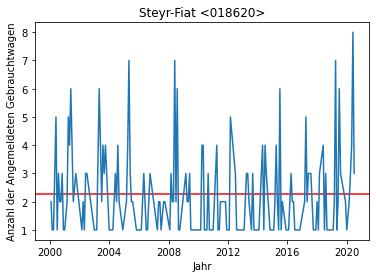

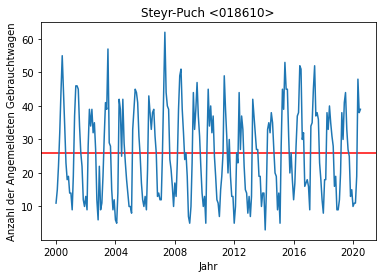

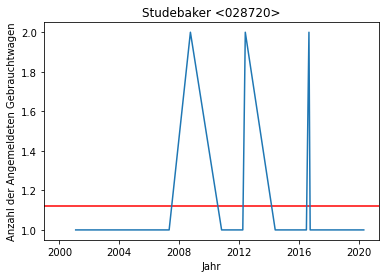

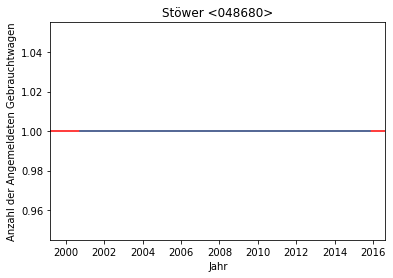

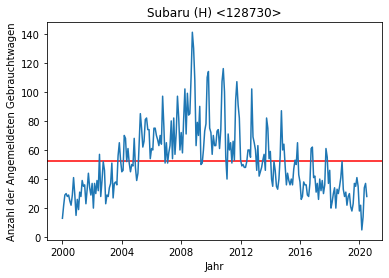

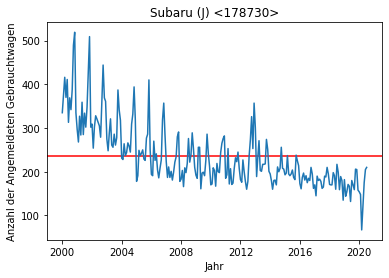

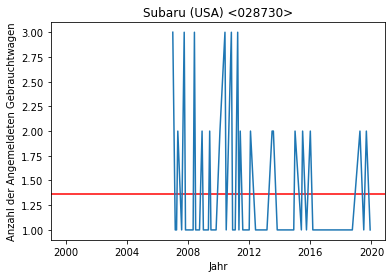

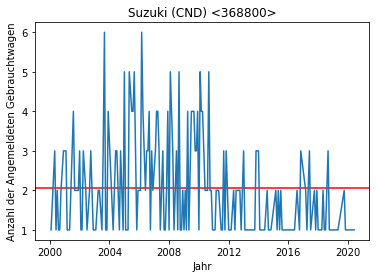

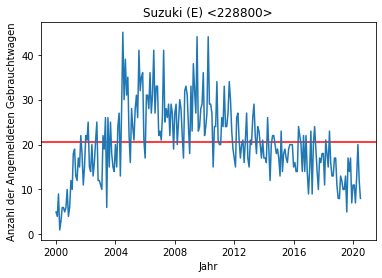

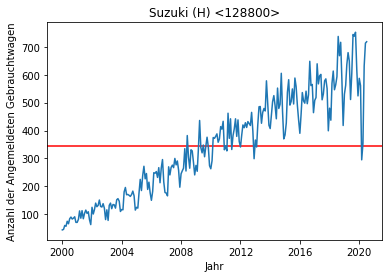

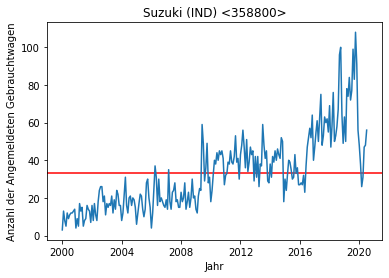

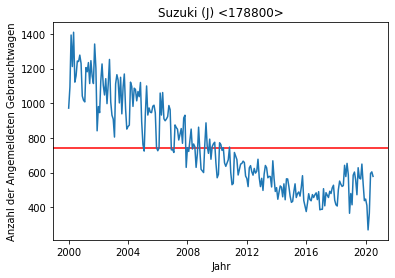

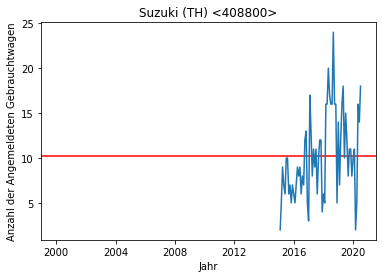

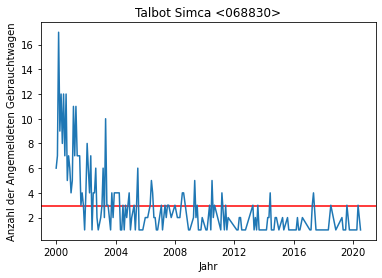

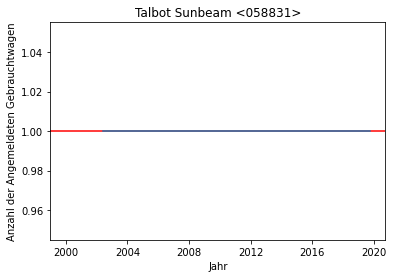

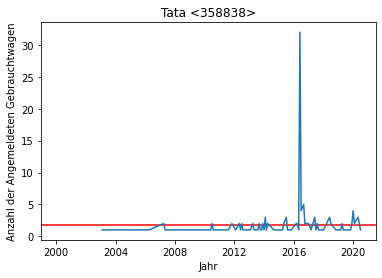

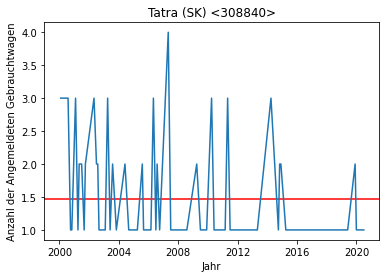

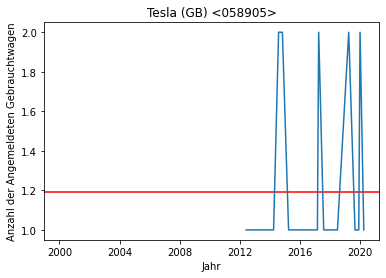

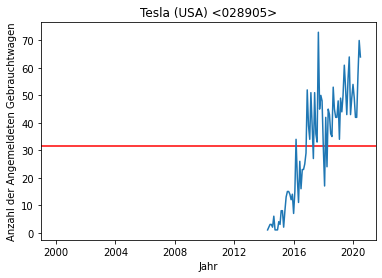

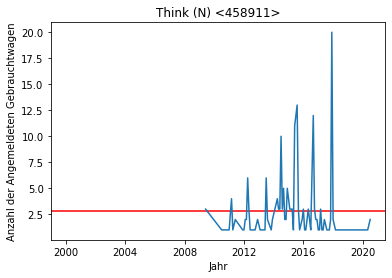

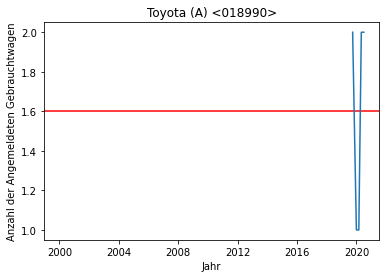

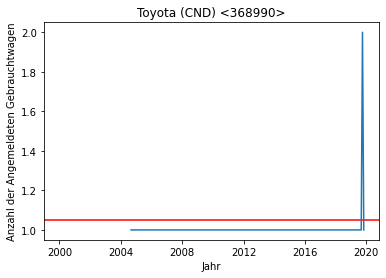

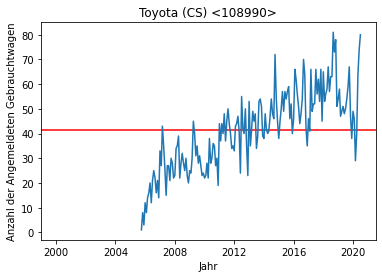

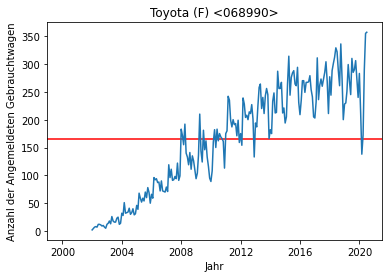

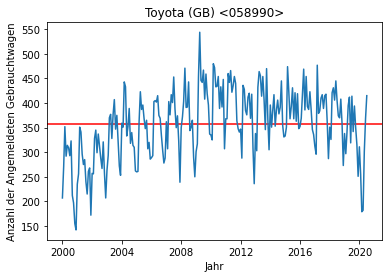

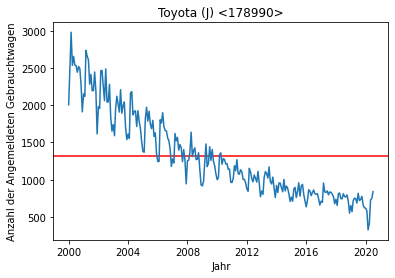

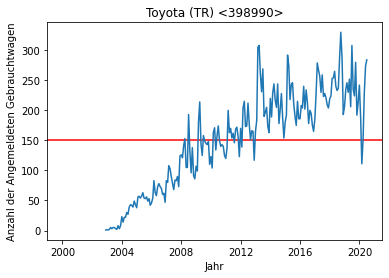

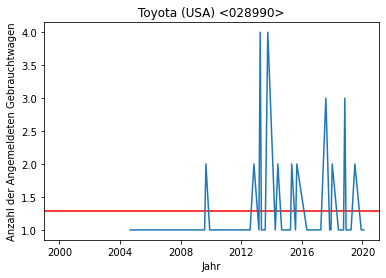

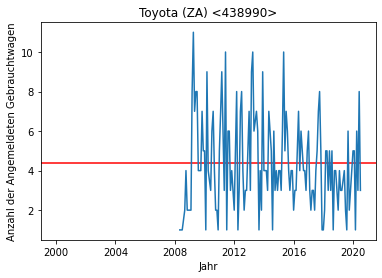

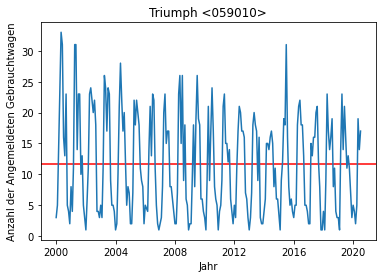

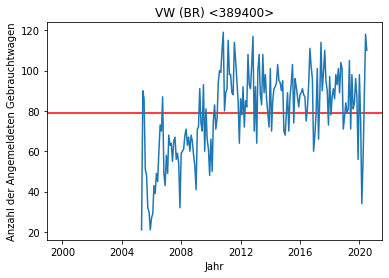

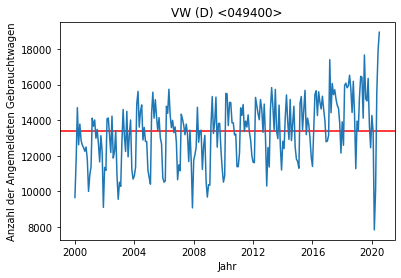

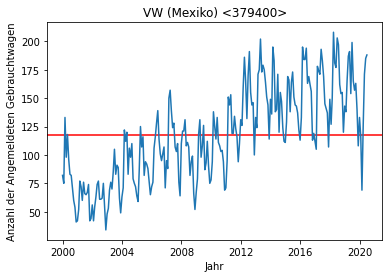

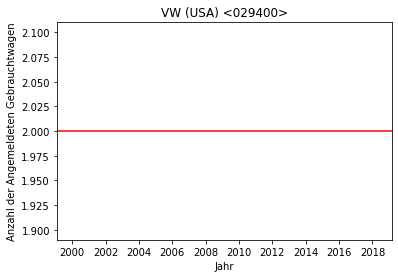

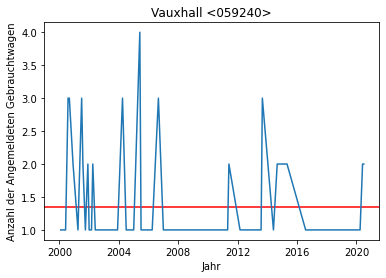

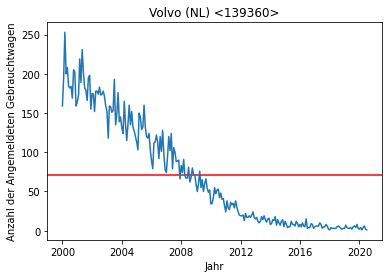

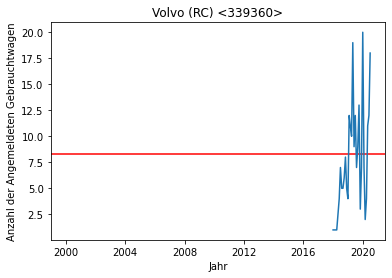

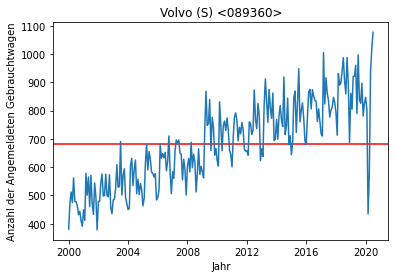

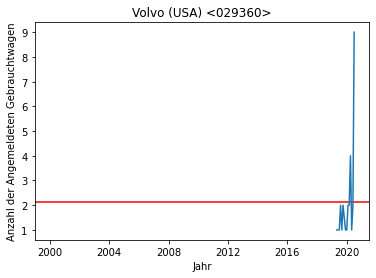

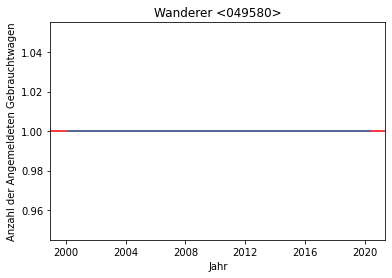

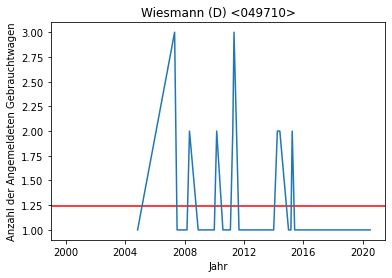

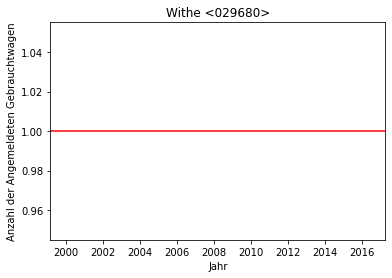

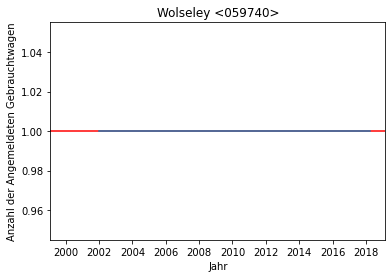

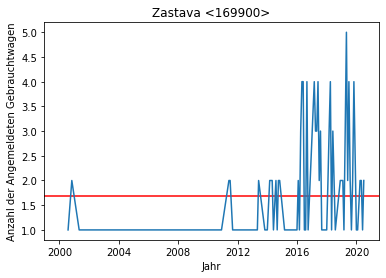

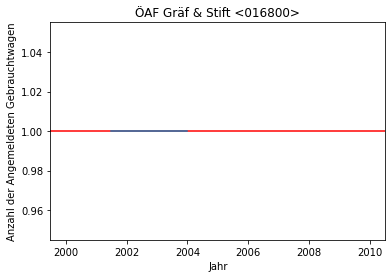

In [8]:
## Plot


print(display(HTML("<h2>Plot für alle Gebrauchtwägen</h2>")))
datumList = []
anzahlList = []
for key in sorted(gesamt):
    datumList.append(key)
    anzahlList.append(gesamt.get(key))

plt.axhline(sum(anzahlList) / len(anzahlList), c='red')
plt.ylabel('Anzahl der Angemeldeten Gebrauchtwagen')
plt.xlabel('Jahr')
plt.plot(datumList, anzahlList)
plt.show()

print(display(HTML("<h2>Plot für Einzelne Marken</h2>")))
for df in dfList:
    
    x = df["Datum"].values
    y = df["Anzahl"].values
    if not pd.isnull(df["marke"].values[0]):
        plt.title(df["marke"].values[0])
        
    plt.axhline(y.mean(), c='red')
    plt.ylabel('Anzahl der Angemeldeten Gebrauchtwagen')
    plt.xlabel('Jahr')
    plt.plot(x, y)
    plt.show()
  


In [11]:
# Export
import os

os.system('jupyter nbconvert --output-dir="../../kienil.github.io/pkw" --TemplateExporter.exclude_input=True --to html pkw-zulassung.ipynb --output index.html')
os.system('jupyter nbconvert --output-dir="../../kienil.github.io/pkw" --to html pkw-zulassung.ipynb --output index_developer.html')


0